In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.stattools import durbin_watson
from statsmodels.imputation.mice import MICEData
import statsmodels.api as sm

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

MODELING

In [2]:
Df2015 = pd.read_csv('SourceData/2015.csv')
Df2016 = pd.read_csv('SourceData/2016.csv')
Df2017 = pd.read_csv('SourceData/2017.csv')
Df2018 = pd.read_csv('SourceData/2018.csv')
Df2019 = pd.read_csv('SourceData/2019.csv')

Easy version, modeling with the features that presents no problems to merge

In [3]:
CountriesToRegion = dict(zip(Df2015['Country'], Df2015['Region']))

In [4]:
#Reordering the data
Df2015 = Df2015[['Region', 'Happiness Score', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity']]
Df2016 = Df2016[['Region', 'Happiness Score', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity']]
Df2017 = Df2017[['Country', 'Happiness.Score', 'Economy..GDP.per.Capita.', 'Family', 'Health..Life.Expectancy.', 'Freedom', 'Trust..Government.Corruption.', 'Generosity']]
Df2018 = Df2018[['Country or region', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']]
Df2019 = Df2019[['Country or region', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']]

In [5]:
#Normalizing column names for concatenating
Df2017.columns = Df2018.columns = Df2019.columns = Df2015.columns

#Mapping countries to regions
Df2017['Region'] = Df2017['Region'].map(CountriesToRegion).values
Df2018['Region'] = Df2018['Region'].map(CountriesToRegion).values
Df2019['Region'] = Df2019['Region'].map(CountriesToRegion).values

In [6]:
Df = pd.concat([Df2015, Df2016, Df2017, Df2018, Df2019], axis=0)
Df

,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity
0,Western Europe,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678
1,Western Europe,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630
2,Western Europe,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139
3,Western Europe,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699
4,North America,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811
...,...,...,...,...,...,...,...,...
151,Sub-Saharan Africa,3.334,0.35900,0.71100,0.61400,0.55500,0.41100,0.21700
152,Sub-Saharan Africa,3.231,0.47600,0.88500,0.49900,0.41700,0.14700,0.27600
153,Southern Asia,3.203,0.35000,0.51700,0.36100,0.00000,0.02500,0.15800
154,Sub-Saharan Africa,3.083,0.02600,0.00000,0.10500,0.22500,0.03500,0.23500


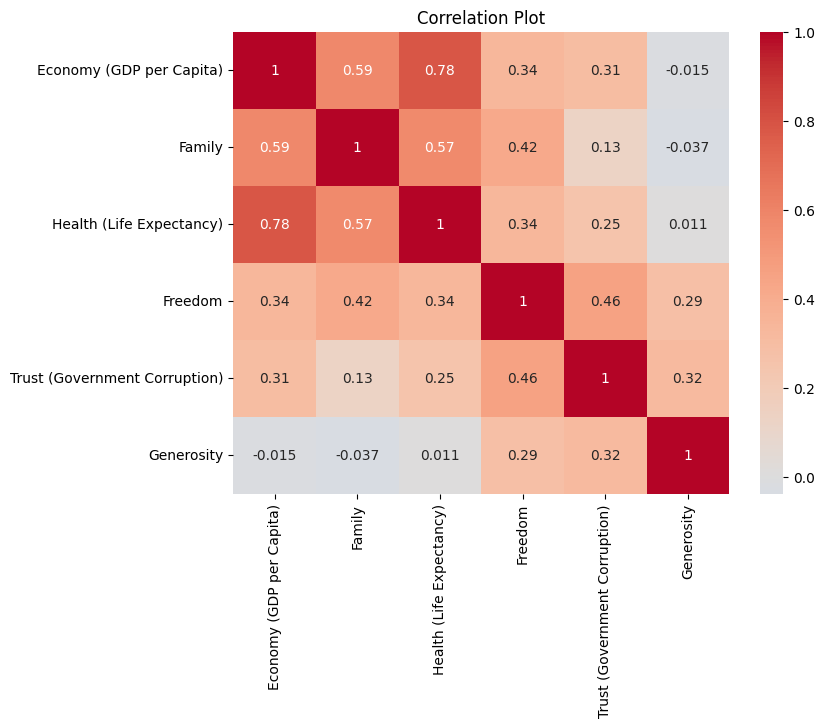

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(Df.drop(['Region', 'Happiness Score'], axis=1).corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Plot")
plt.show()

In [8]:
DummyDf =  pd.get_dummies(Df, columns=['Region'], drop_first=True)
DummyDf.drop('Health (Life Expectancy)', axis=1, inplace=True) #Because of high correlation with the gdp variable
DummyDf = DummyDf.loc[~(DummyDf['Generosity'].isna())]
DummyDf = DummyDf.loc[~(DummyDf['Trust (Government Corruption)'].isna())]
DummyDf

,Happiness Score,Economy (GDP per Capita),Family,Freedom,Trust (Government Corruption),Generosity,Region_Central and Eastern Europe,Region_Eastern Asia,Region_Latin America and Caribbean,Region_Middle East and Northern Africa,Region_North America,Region_Southeastern Asia,Region_Southern Asia,Region_Sub-Saharan Africa,Region_Western Europe
0,7.587,1.39651,1.34951,0.66557,0.41978,0.29678,False,False,False,False,False,False,False,False,True
1,7.561,1.30232,1.40223,0.62877,0.14145,0.43630,False,False,False,False,False,False,False,False,True
2,7.527,1.32548,1.36058,0.64938,0.48357,0.34139,False,False,False,False,False,False,False,False,True
3,7.522,1.45900,1.33095,0.66973,0.36503,0.34699,False,False,False,False,False,False,False,False,True
4,7.427,1.32629,1.32261,0.63297,0.32957,0.45811,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,3.334,0.35900,0.71100,0.55500,0.41100,0.21700,False,False,False,False,False,False,False,True,False
152,3.231,0.47600,0.88500,0.41700,0.14700,0.27600,False,False,False,False,False,False,False,True,False
153,3.203,0.35000,0.51700,0.00000,0.02500,0.15800,False,False,False,False,False,False,True,False,False
154,3.083,0.02600,0.00000,0.22500,0.03500,0.23500,False,False,False,False,False,False,False,True,False


In [9]:
np.random.seed(1738)

In [10]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(DummyDf.drop('Happiness Score', axis=1), DummyDf['Happiness Score'], train_size=.7)

In [11]:
Lr = linear_model.LinearRegression()
Lr.fit(X_Train.values, Y_Train.values)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


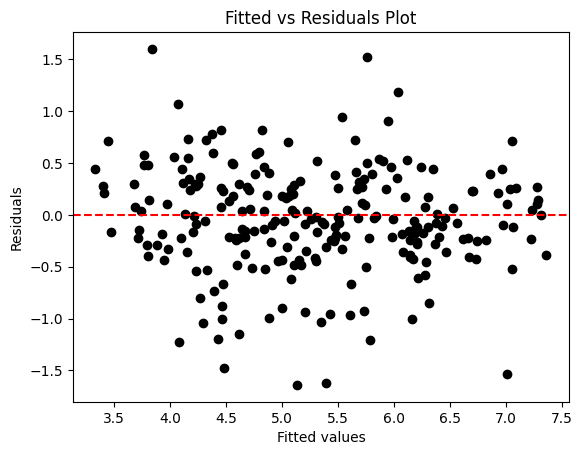

In [12]:
#Model validity checks
Model1Predictors = Lr.predict(X_Test.values)
Model1Residuals = Y_Test.values - Model1Predictors

# Fitted vs Residuals plot
plt.scatter(Model1Predictors, Model1Residuals, color='black')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residuals Plot")
plt.show()

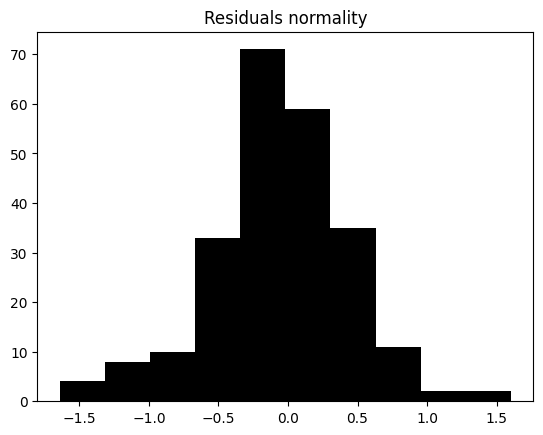

In [13]:
plt.hist(Model1Residuals, color='black')
plt.title('Residuals normality')
plt.show()

In [14]:
DW = durbin_watson(Model1Residuals)
print("Estadístico Durbin-Watson:", DW)

Estadístico Durbin-Watson: 1.7754243856350294


In [15]:
R_2Model1 = r2_score(Y_Test, Model1Predictors)
print('R squared:', R_2Model1)

R_2AdjModel1 = 1 - (1 - R_2Model1) * ((len(X_Test) - 1) / (len(X_Test) - len(X_Test.columns) - 1))
print('R squared adjusted:', R_2AdjModel1)

RMSE = np.sqrt(mean_squared_error(Y_Test, Model1Predictors))
print('Root mean squared error:', RMSE)

MAPE = mean_absolute_percentage_error(Y_Test, Model1Predictors) * 100
print('Mean absolute percentage error:', MAPE)

R squared: 0.7725147783151807
R squared adjusted: 0.7580384460261467
Root mean squared error: 0.5115801704805036
Mean absolute percentage error: 8.119933794768482


Version 2

In [16]:
Lr2 = linear_model.LinearRegression()
SFS = SequentialFeatureSelector(
    Lr2,
    n_features_to_select="auto",  
    direction="forward"
)
SFS.fit(X_Train, Y_Train)

Features = SFS.get_feature_names_out()
print(Features)
X_selected = X_Train[Features]
Lr2.fit(X_selected, Y_Train)

['Economy (GDP per Capita)' 'Family' 'Freedom'
 'Trust (Government Corruption)' 'Region_Latin America and Caribbean'
 'Region_North America' 'Region_Western Europe']


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [17]:
Model2Predictors = Lr2.predict(X_Test[Features].values)
Model2Residuals = Y_Test.values - Model2Predictors

c:\Users\Marco Antonio Aragon\Documents\VSC\ETL\Workshop3\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [18]:
R_2Model2 = r2_score(Y_Test, Model2Predictors)
print('R squared:', R_2Model2)

R_2AdjModel2 = 1 - (1 - R_2Model2) * ((len(X_Test) - 1) / (len(X_Test) - len(X_Test.columns) - 1))
print('R squared adjusted:', R_2AdjModel2)

RMSE = np.sqrt(mean_squared_error(Y_Test, Model2Predictors))
print('Root mean squared error:', RMSE)

MAPE = mean_absolute_percentage_error(Y_Test, Model2Predictors) * 100
print('Mean absolute percentage error:', MAPE)

R squared: 0.7674056501174682
R squared adjusted: 0.7526041914885798
Root mean squared error: 0.5172931034717647
Mean absolute percentage error: 8.183330152573095


MICE inputation - feature selection modeling

In [19]:
Df2015 = pd.read_csv('SourceData/2015.csv')
Df2016 = pd.read_csv('SourceData/2016.csv')
Df2017 = pd.read_csv('SourceData/2017.csv')
Df2018 = pd.read_csv('SourceData/2018.csv')
Df2019 = pd.read_csv('SourceData/2019.csv')

In [20]:
#Dropping useless features
Df2015.drop(['Country', 'Standard Error', 'Happiness Rank'], axis=1, inplace=True)
Df2016.drop(['Country', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Happiness Rank'], axis=1, inplace=True)
Df2017.drop(['Whisker.high', 'Whisker.low', 'Happiness.Rank'], axis=1, inplace=True)
Df2018.drop('Overall rank', axis=1, inplace=True)
Df2019.drop('Overall rank', axis=1, inplace=True)

In [21]:
#Normalizing columns to merge
Df2017 = Df2017[['Country', 'Happiness.Score', 'Economy..GDP.per.Capita.', 'Family', 'Health..Life.Expectancy.', 'Freedom', 'Trust..Government.Corruption.', 'Generosity','Dystopia.Residual']]
Df2017.columns = Df2016.columns
Df2018 = Df2018[['Country or region', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']]
Df2018.columns = ['Region', 'Happiness Score', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity']
Df2019 = Df2019[['Country or region', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Perceptions of corruption', 'Generosity']]
Df2019.columns = ['Region', 'Happiness Score', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity']

In [22]:
Df2017['Region'] = Df2017['Region'].map(CountriesToRegion).values
Df2018['Region'] = Df2018['Region'].map(CountriesToRegion).values
Df2019['Region'] = Df2019['Region'].map(CountriesToRegion).values

In [23]:
Df = pd.concat([Df2015, Df2016, Df2017, Df2018, Df2019], axis=0)
Df

,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Western Europe,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Western Europe,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Western Europe,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Western Europe,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,North America,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176
...,...,...,...,...,...,...,...,...,...
151,Sub-Saharan Africa,3.334,0.35900,0.71100,0.61400,0.55500,0.41100,0.21700,NaN
152,Sub-Saharan Africa,3.231,0.47600,0.88500,0.49900,0.41700,0.14700,0.27600,NaN
153,Southern Asia,3.203,0.35000,0.51700,0.36100,0.00000,0.02500,0.15800,NaN
154,Sub-Saharan Africa,3.083,0.02600,0.00000,0.10500,0.22500,0.03500,0.23500,NaN


In [24]:
Nulls = Df.isnull().sum()
NullsPctg = (Df.isnull().mean() * 100)

pd.DataFrame({
    'Cantidad_Nulos': Nulls,
    'Porcentaje_Nulos': NullsPctg
})

,Cantidad_Nulos,Porcentaje_Nulos
Region,19,2.429668
Happiness Score,0,0.000000
Economy (GDP per Capita),0,0.000000
Family,0,0.000000
Health (Life Expectancy),0,0.000000
Freedom,0,0.000000
Trust (Government Corruption),1,0.127877
Generosity,0,0.000000
Dystopia Residual,312,39.897698


In [25]:
Df.columns = [Column.replace(' ', '_').replace('(', '').replace(')', '') for Column in Df.columns]

In [26]:
Predictors = Df.drop(columns=['Happiness_Score', 'Region'])
MiceData = MICEData(Predictors)

for i in range(20): 
    MiceData.update_all()
      
ImputedDf = MiceData.data.copy()
ImputedDf['Region'] = Df['Region'].values
ImputedDf['Happiness_Score'] = Df['Happiness_Score'].values
ImputedDf.to_csv('StagingData/InputedData.csv', index=False)

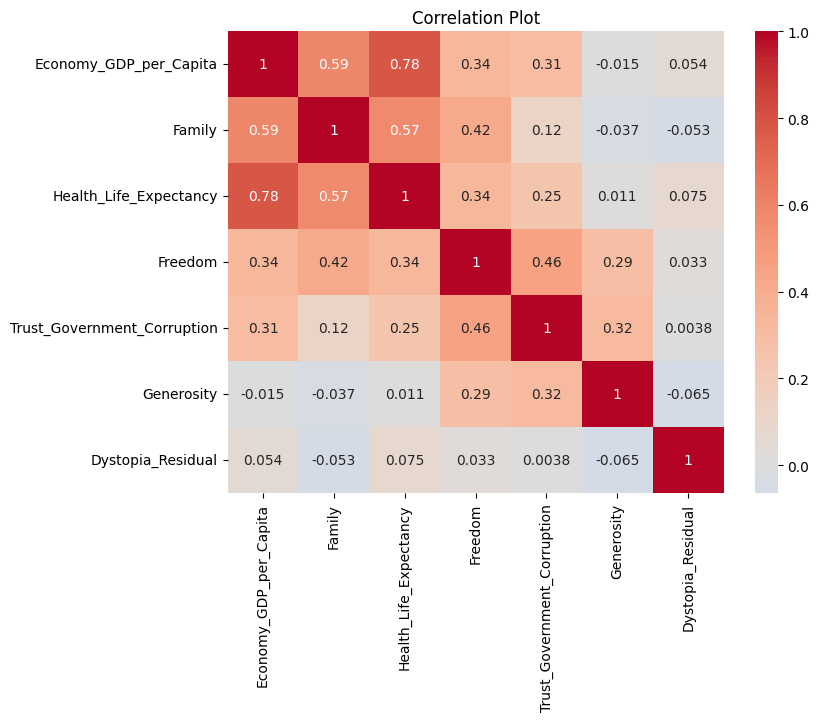

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(ImputedDf.drop(['Region', 'Happiness_Score'], axis=1).corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Plot")
plt.show()

In [28]:
DummyDf = pd.get_dummies(ImputedDf, columns=['Region'], drop_first=True)
DummyDf.drop('Health_Life_Expectancy', axis=1, inplace=True)
DummyDf

,Economy_GDP_per_Capita,Family,Freedom,Trust_Government_Corruption,Generosity,Dystopia_Residual,Happiness_Score,Region_Central and Eastern Europe,Region_Eastern Asia,Region_Latin America and Caribbean,Region_Middle East and Northern Africa,Region_North America,Region_Southeastern Asia,Region_Southern Asia,Region_Sub-Saharan Africa,Region_Western Europe
0,1.39651,1.34951,0.66557,0.41978,0.29678,2.517380,7.587,False,False,False,False,False,False,False,False,True
1,1.30232,1.40223,0.62877,0.14145,0.43630,2.702010,7.561,False,False,False,False,False,False,False,False,True
2,1.32548,1.36058,0.64938,0.48357,0.34139,2.492040,7.527,False,False,False,False,False,False,False,False,True
3,1.45900,1.33095,0.66973,0.36503,0.34699,2.465310,7.522,False,False,False,False,False,False,False,False,True
4,1.32629,1.32261,0.63297,0.32957,0.45811,2.451760,7.427,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0.35900,0.71100,0.55500,0.41100,0.21700,1.567260,3.334,False,False,False,False,False,False,False,True,False
778,0.47600,0.88500,0.41700,0.14700,0.27600,2.214890,3.231,False,False,False,False,False,False,False,True,False
779,0.35000,0.51700,0.00000,0.02500,0.15800,2.438010,3.203,False,False,False,False,False,False,True,False,False
780,0.02600,0.00000,0.22500,0.03500,0.23500,2.234840,3.083,False,False,False,False,False,False,False,True,False


In [29]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(DummyDf.drop('Happiness_Score', axis=1).astype(float), DummyDf['Happiness_Score'], train_size=.7)

In [30]:
X_Test.to_csv('StagingData/XTesting.csv', index=False)
Y_Test.to_csv('StagingData/YTesting.csv', index=False)

In [31]:
Lr3 = linear_model.LinearRegression()
SFS = SequentialFeatureSelector(
    Lr3,
    n_features_to_select="auto",  
    direction="forward"
)
SFS.fit(X_Train, Y_Train)

Features = SFS.get_feature_names_out()
print(Features)
X_selected = X_Train[Features]
Lr3.fit(X_selected, Y_Train)

['Economy_GDP_per_Capita' 'Family' 'Freedom' 'Generosity'
 'Dystopia_Residual' 'Region_Latin America and Caribbean'
 'Region_Western Europe']


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
model = sm.OLS(Y_Train, sm.add_constant(X_Train[Features])).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Happiness_Score   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     522.2
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          1.85e-235
Time:                        18:25:58   Log-Likelihood:                -274.17
No. Observations:                 547   AIC:                             564.3
Df Residuals:                     539   BIC:                             598.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

c:\Users\Marco Antonio Aragon\Documents\VSC\ETL\Workshop3\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


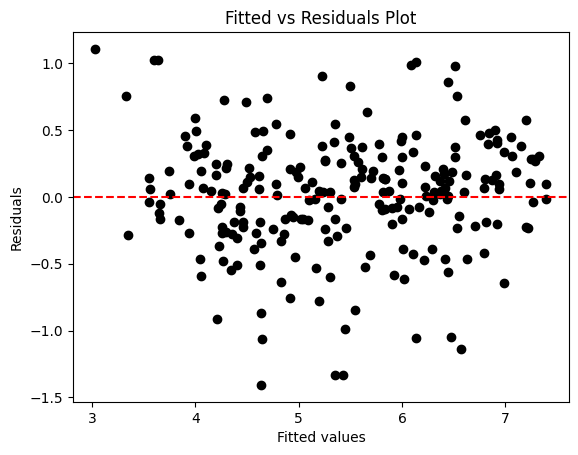

In [33]:
#Model validity checks
Model3Predictors = Lr3.predict(X_Test[Features].values)
Model3Residuals = Y_Test.values - Model3Predictors

# Fitted vs Residuals plot
plt.scatter(Model3Predictors, Model3Residuals, color='black')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residuals Plot")
plt.show()

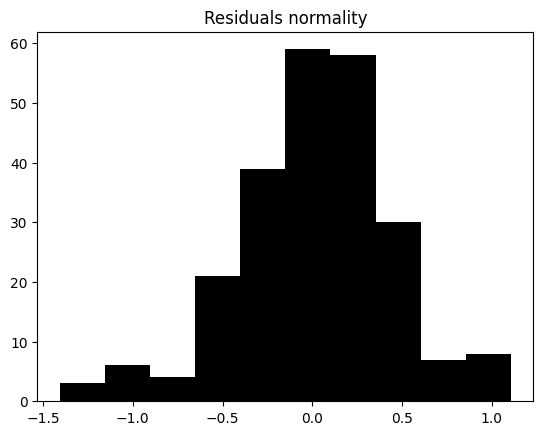

In [34]:
plt.hist(Model3Residuals, color='black')
plt.title('Residuals normality')
plt.show()

In [35]:
DW = durbin_watson(Model3Residuals)
print("Estadístico Durbin-Watson:", DW)

Estadístico Durbin-Watson: 1.8996607761063438


In [36]:
R_2Model3 = r2_score(Y_Test, Model3Predictors)
print('R squared:', R_2Model3)

R_2AdjModel3 = 1 - (1 - R_2Model3) * ((len(X_Test) - 1) / (len(X_Test) - len(X_Test.columns) - 1))
print('R squared adjusted:', R_2AdjModel3)

RMSE = np.sqrt(mean_squared_error(Y_Test, Model3Predictors))
print('Root mean squared error:', RMSE)

MAPE = mean_absolute_percentage_error(Y_Test, Model3Predictors) * 100
print('Mean absolute percentage error:', MAPE)

R squared: 0.8587472573802368
R squared adjusted: 0.8490724119953216
Root mean squared error: 0.4329312449082461
Mean absolute percentage error: 6.441151966384254


This results conclude that the best model to keep and export is the last one

In [37]:
joblib.dump(Lr3, 'Model.pkl')

['Model.pkl']

In [38]:
np.mean(Y_Train)

np.float64(5.347318100523033)

In [39]:
np.mean(Model3Predictors)

np.float64(5.4327445165673955)

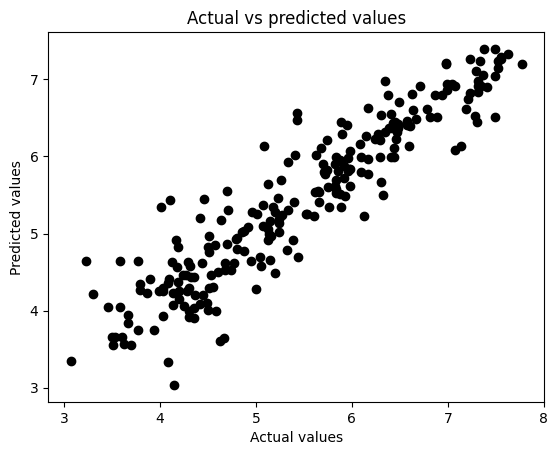

In [ ]:
plt.scatter(Y_Test, Model3Predictors, color='black')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs predicted values")
plt.show()

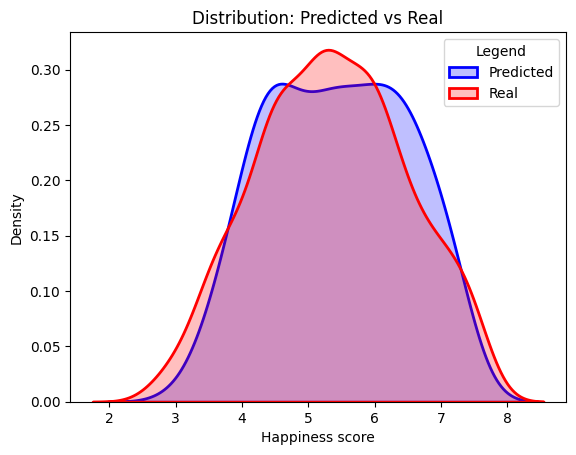

In [ ]:
sns.kdeplot(data=Model3Predictors, fill=True, color="blue", linewidth=2, label="Predicted")
sns.kdeplot(data=Y_Train, fill=True, color="red", linewidth=2, label="Real")

plt.title("Distribution: Predicted vs Real")
plt.xlabel("Happiness score")
plt.ylabel("Density")
plt.legend(title="Legend") 
plt.show()